# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

import seaborn as sns
sns.set()

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [446]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [447]:
#regroup df for unique number of articles read by user
df_articles = df.groupby(['email'])['article_id'].nunique()
max_user_interactions = df.groupby('email')['article_id'].count().max()
#print min, max, mean
print('max interactions: {}'.format(max_user_interactions))
print('min interactions: ', df_articles.min())
print('mean interactions: ', df_articles.mean())
print('median interactions: ', df_articles.median())

max interactions: 364
min interactions:  1
mean interactions:  6.54020979020979
median interactions:  3.0


In [448]:
def user_inter_hist(values, x_label, y_label, title, bin_min=0, bin_max=140, bin_step=5, fig_width=15, fig_height=10, **kwargs):
    """
    The function plots a histogram for user interactions with articles on IBM Watson.
    It saves the histogram as a PNG-file

    Args:
        values (df): df of user interactions with articles
        x_label (string): label for x-axis
        y_label (string): label for y_axis
        title (string): label for plot
        bin_min (int): min range for x-axis
        bin_max (int): max range for x_axis
        bin_step (int): step size for x_axis
    Returns:
        None
    """
    #determine number of bins for histogram
    bins = np.arange(bin_min, bin_max, bin_step)

    #specify plot style from seaborn library
    plt.style.use('fivethirtyeight')

    #specify figsize
    plt.figure(figsize=(fig_width,fig_height))

    #plot the graph
    plt.hist(values, bins=bins, rwidth=.8, alpha=.8)

    #specify title
    plt.title(title)

    #specify label x-axis
    plt.xlabel(x_label)

    #specify label y-axis
    plt.ylabel(y_label)

    #save figure
    plt.savefig('IBM_user interactions with items.png')

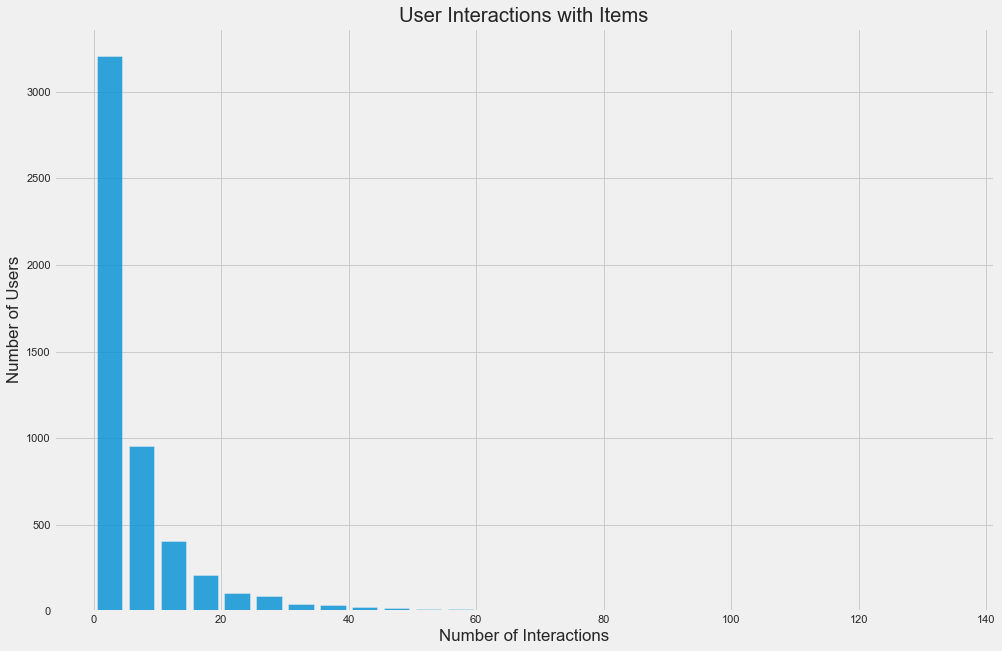

In [449]:
user_inter_hist(values=df_articles, x_label='Number of Interactions', y_label='Number of Users', title='User Interactions with Items')

Most users interact with 1 to 5 articles and that's it. Intuitivly, number of users interacting with more and more articles decreases. The max interactions of a user is with 135 unique articles. Either that user is really, really valuable to the platform, or it's an admin.
The main goal of any recommendation algorithm should be to move the big bulk of users interacting with only a few articles up the graph!

In [450]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3.0 # 50% of individuals interact with __5__ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ___135___.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [451]:
# Find and explore duplicate articles
duplicate_articles = list(df_content[df_content.duplicated(['article_id'], keep=False)]['article_id'])
print(duplicate_articles)

[50, 221, 232, 50, 398, 577, 221, 398, 577, 232]


In [452]:
#use the duplicate_articles-list to get a new content_df
new = df_content['article_id'].isin(duplicate_articles)
print(df_content[new])

                                              doc_body  \
50   Follow Sign in / Sign up Home About Insight Da...   
221  * United States\r\n\r\nIBM® * Site map\r\n\r\n...   
232  Homepage Follow Sign in Get started Homepage *...   
365  Follow Sign in / Sign up Home About Insight Da...   
399  Homepage Follow Sign in Get started * Home\r\n...   
578  This video shows you how to construct queries ...   
692  Homepage Follow Sign in / Sign up Homepage * H...   
761  Homepage Follow Sign in Get started Homepage *...   
970  This video shows you how to construct queries ...   
971  Homepage Follow Sign in Get started * Home\r\n...   

                                       doc_description  \
50                        Community Detection at Scale   
221  When used to make sense of huge amounts of con...   
232  If you are like most data scientists, you are ...   
365  During the seven-week Insight Data Engineering...   
399  Today’s world of data science leverages data f...   
578  This vid

In [453]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)
df_content = df_content.reset_index(drop=True)

In [454]:
#check if dropping the duplicates worked
list(df_content[df_content.duplicated(['article_id'], keep=False)]['article_id'])

[]

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [455]:
def task_3():
    """
    Compute answers to questions of part 3

    Args:
        None
    Returns:
        None
    """
    #number of unique articles with user interactions
    print('unique_articles: ', (df.groupby('article_id')['email'].count()>0).sum())

    #number of unique articles
    print('total_articles: ', df_content['article_id'].nunique())

    #number of unique users
    print('unique_users: ', df_unstacked.shape[0])

    #number of user-article interactions
    print('user_article_interactions: ', df.shape[0])


In [456]:
task_3()

unique_articles:  714
total_articles:  1051
unique_users:  5148
user_article_interactions:  45993


In [457]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [458]:
#most viewed article and number of viewings 
most_viewed_articles = pd.DataFrame(df.groupby(['article_id'])['email'].count().sort_values(ascending=False)).reset_index().loc[0]
most_viewed_articles

article_id    1429.0
email          937.0
Name: 0, dtype: float64

In [459]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [460]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [461]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Exploratory-Data-Analysis">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [541]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    #sort articles for number of interactions
    articles = pd.DataFrame(df.groupby(['article_id', 'title'])['user_id'].count().sort_values(ascending=False)).reset_index()

    #store result in list and extract only article_ids
    top_articles = list(articles['title'])

    #extract specified number of top articles
    top_articles = top_articles[:n]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    #sort articles for number of interactions
    articles = pd.DataFrame(df.groupby(['article_id'])['user_id'].count().sort_values(ascending=False)).reset_index()

    #store result in list and extract only article_ids
    top_articles = articles['article_id']

    #fix after realizing this needs to be a string list
    top_articles = list(map(lambda a: str(a), top_articles))

    #extract specified number of top articles
    top_articles = top_articles[:n]

    return top_articles # Return the top article ids

In [542]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [538]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [466]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_by_article = df.groupby(['user_id', 'article_id'])['title'].max().unstack(fill_value=0)
    user_item = user_by_article.replace(to_replace=r'\D', value=1, regex=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [467]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [468]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    first_items = user_item.loc[user_id]

    columns = ['first_user', 'second_user', 'dot_product']

    dot_df = pd.DataFrame(columns=columns)

    #compare using dot-product
    for comp in user_item.index:
        second_items = user_item.loc[comp]
        user_sim = np.dot(first_items, second_items.T)
        user_row = pd.DataFrame(np.array([[user_id, comp, user_sim]]), columns=['first_user', 'second_user', 'dot_product'])
        dot_df = dot_df.append(user_row, ignore_index = True)

    dot_df['first_user'], dot_df['second_user'] = dot_df['first_user'].astype(int), dot_df['second_user'].astype(int)

    # sort by similarity
    dot_df = dot_df.sort_values(by='dot_product', ascending=False)

    # create list of just the ids
    most_similar_users = dot_df['second_user'].values.tolist()
    

    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [469]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [470]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    #create working copy
    df_articles = df.copy()

    #drop any duplicates in article_id
    df_articles.drop_duplicates(subset='article_id', inplace=True)

    #get titles for article_ids
    article_names = list(df_articles[df_articles['article_id'].isin(article_ids)]['title'])

    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    #get article_ids for user
    article_ids = user_item.loc[user_id][user_item.loc[user_id]!=0].index.values.astype(str)

    #create list for articles, get doc_full_name or title
    article_names = []

    for ids in article_ids:
        try:
            article_names.append(df_content.query('article_id==@ids')['doc_full_name'].values[0].lower())
        except:
            article_names.append(df.query('article_id==@ids')['title'].values[0])
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    #create list for recs
    recs = []

    #get self interacted articles
    self_articles = user_item.loc[user_id][user_item.loc[user_id]!=0].index.values

    #find similar users
    closest_users = find_similar_users(user_id)

    #get neighbor interacted articles and diff to self for recs
    for users in closest_users:
        neighbor_articles = user_item.loc[users][user_item.loc[users]!=0].index.values
        new_recs = np.setdiff1d(neighbor_articles, self_articles, assume_unique=True)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        if len(recs) > m-1:
            recs = recs[:m]

    return recs # return your recommendations for this user_id    

In [471]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'the greatest public datasets for ai – startup grind',
 '3992    using apache spark to predict attack vectors a...\nName: title, dtype: object',
 'detect malfunctioning iot sensors with streaming analytics',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'apache spark™ 2.0: extend structured streaming for spark ml',
 'data science bowl 2017',
 'analyze ny restaurant data using spark in dsx']

In [472]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [473]:
num_user_df = pd.DataFrame(df.groupby('user_id')['article_id'].count().sort_values(ascending=False))
num_user_df.head()

,article_id
user_id,
23,364
3782,363
98,170
3764,169
203,160


In [474]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    user_interactions = df.groupby(['user_id'])['article_id'].count()

    # compute similarity of each user to the provided user
    n_users = user_item.shape[0]
    
    # columns
    neighbor_id = [uid for uid in range(1, n_users) if uid != user_id]
    similarity = []
    num_interactions = []
    
    # set similarity and num_interactions
    for uid in neighbor_id:
        similarity.append(np.dot(user_item.loc[user_id], user_item.loc[uid]))
        num_interactions.append(user_interactions.loc[uid])
        
    # create dataframe
    neighbors_df = pd.DataFrame({
        'neighbor_id': neighbor_id,
        'similarity': similarity,
        'num_interactions': num_interactions
    })
    
    # sort dataframe by similarity
    neighbors_df.sort_values('similarity', ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    neighbors_df = get_top_sorted_users(user_id)
    
    # set top-m neighbor_id
    top_m_neighbors = list(neighbors_df[:m]['neighbor_id'])

    # set article_ids seen by top-m neighbors
    recs = []
    for uid in top_m_neighbors:
        article_ids = user_item.loc[uid]
        recs.extend([str(aid) for aid in article_ids[article_ids == 1].index])

    # remove duplicate
    recs = list(set(recs[:m]))

    # set article names and remove duplicate
    rec_names = list(set(df[df['article_id'].isin(recs)]['title']))

    return recs, rec_names

In [475]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['981.0', '232.0', '1186.0', '89.0', '1271.0', '53.0', '793.0', '495.0', '1053.0', '727.0']

The top 10 recommendations for user 20 are the following article names:
['connect to db2 warehouse on cloud and db2 using scala', 'customer demographics and sales', 'from python nested lists to multidimensional numpy arrays', 'introducing streams designer', 'top 20 r machine learning and data science packages', 'access mysql with python', 'self-service data preparation with ibm data refinery', 'super fast string matching in python', 'top 10 machine learning algorithms for beginners', '10 powerful features on watson data platform, no coding necessary']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [476]:
#most similar user to user 1
get_top_sorted_users(1).iloc[0]

neighbor_id         3933
similarity            35
num_interactions      45
Name: 3931, dtype: int64

In [477]:
#10th most similar user to user 131
get_top_sorted_users(131).iloc[9]

neighbor_id         242
similarity           25
num_interactions    148
Name: 240, dtype: int64

In [478]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [479]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Since a new user has not yet interated with any or enough articles yet, we should use the function "get_top_article_ids" or "get_top_articles" to make recommendations. That is, because we would propably not find the user in our user_item dataframe, so we can't use collaborative filtering methods but need to resort to ranked-based solutions instead. However, an improvment to the current solution could be trying to sort articles into semantic clusters, for example topic-wise, and recommend only articles within the same segment a user has already shown interest in. Of course, this approach only works too, if the user has already interacted with at least 1 article. For other users, we can still resort back to the rank-based approach.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [539]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)
print(new_user_recs)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [540]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [632]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [633]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [634]:
#check, if user-item matrix has missing values
user_item.isnull().mean()

article_id
0.0       0.0
2.0       0.0
4.0       0.0
8.0       0.0
9.0       0.0
         ... 
1440.0    0.0
1441.0    0.0
1442.0    0.0
1443.0    0.0
1444.0    0.0
Length: 714, dtype: float64

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [635]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item) # use the built in to get the three matrices

There are no missing values in the user-item matrix, so SVD is in fact a valid option here and won't fail like in the lessons.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [636]:
print('u.shape:  {}\ns.shape:  {}\nvt.shape: {}'.format(u.shape, s.shape, vt.shape))

u.shape:  (5149, 5149)
s.shape:  (714,)
vt.shape: (714, 714)


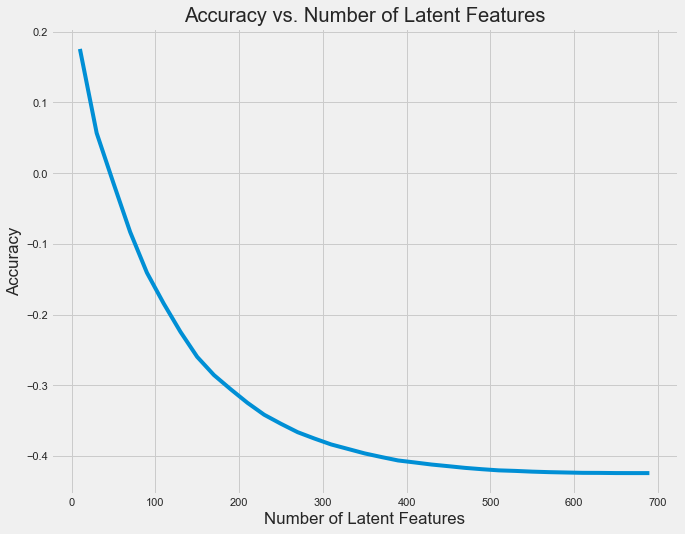

In [637]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

plt.style.use('fivethirtyeight')    
plt.figure(figsize=(10, 8));
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [638]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    #create train data
    user_item_train = create_user_item_matrix(df_train)

    #create test data
    user_item_test = create_user_item_matrix(df_test)

    #num users in test data
    test_idx = user_item_test.index

    #num articles in test data
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [639]:
print('user_item_test: ', user_item_test.shape)
print('text_idx:       ', np.isin(user_item_test.index, user_item_train.index).sum())
print('test_arts:      ', np.isin(user_item_test.columns, user_item_train.columns).sum())

user_item_test:  (682, 574)
text_idx:        20
test_arts:       574


In [640]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [641]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

print('u_train.shape:  {}\ns_train.shape:  {}\nvt_train.shape: {}'.format(u.shape, s.shape, vt.shape))

u_train.shape:  (5149, 5149)
s_train.shape:  (714,)
vt_train.shape: (714, 714)


In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [642]:
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

print('u_test.shape:  {}\nvt_test.shape: {}'.format(u_test.shape, vt_test.shape))

u_test.shape:  (20, 4487)
vt_test.shape: (714, 574)


In [645]:
#using the provided code from above

user_item_test_subset = user_item_test.loc[list(set(user_item_train.index) & set(test_idx))]

num_latent_feats = np.arange(10,700+10,20)
train_sum_errs = []
test_sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_subset, user_item_test_est)
    
    # total errors and keep track of them
    train_err = np.sum(np.sum(np.abs(diffs_train)))
    train_sum_errs.append(train_err)
    
    test_err = np.sum(np.sum(np.abs(diffs_test)))
    test_sum_errs.append(test_err)

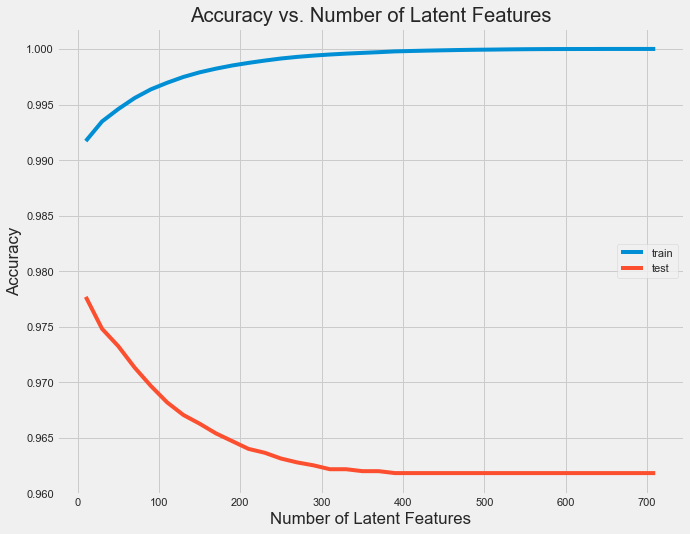

In [644]:
#using provided plot from above
plt.style.use('fivethirtyeight');
plt.figure(figsize=(10, 8));
plt.plot(num_latent_feats, 1 - (np.array(train_sum_errs)/(user_item_train.shape[0]*user_item_train.shape[1])), label='train')
plt.plot(num_latent_feats, 1 - (np.array(test_sum_errs)/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1])), label='test')
plt.legend(loc='right');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 


As it turns out we don't to well predicting on the test set based on the provided training data. Still, we only have 20 users in the test data who are also in the training data so it's really hard to make assumptions about the true accuracy based on the data. If we increase the number of latent features, we should also see an increase in the accuracy of our predictions. On the other hand, the model is based on mostly a sparse matrix, so we may not need to use that many latent features to correctly reporoduce the original matrix. It's sure however, that we can't use a single recommendation model since all of them have their own flaws. What we can try is generate a recommendation from a combination of the models, removing duplicates and providing some kind of ranking.

To improve on that, we could set up an experiment based on a random cookie assignment of users into at least two groups, or many more if we try different combinations of recommendation methods. For that, the invariant metric would be the number of cookies in each group. Evaluation metrics could be numbers of interacted articles in a session. Since we can expect useres to revisit IBM Watson we can sharpen the view by taking the sessions into account and then evaluate if we see an increase in the number of interacted articles per session with the user group(s) getting recommendations from us.

A potential null hypothesis for this could be as such: The number of interacted articles between user groups is exactly the same.

In [647]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0